<a href="https://colab.research.google.com/github/DhanuEdu/DATA-ANALYST-TRAINING--UNIFIED-MENTOR/blob/main/e_com_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1- DATA COLLECTION [download and load dataset]
dataset_url = "https://drive.google.com/uc?id=1EwYcFTnjwuZTpdfd2uaKjNVDLPmRsSMD"
dataset_path = "ecommerce_furniture_dataset.csv"

df = pd.read_csv(dataset_path)

# 2 DATA PREPROCESSING
# removing '$' and converting to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

if 'originalPrice' in df.columns:
    df.loc[:, 'originalPrice'] = df['originalPrice'].replace('[\$,]', '', regex=True).astype(float)
    df.loc[:, 'originalPrice'] = df['originalPrice'].fillna(df['originalPrice'].median())

df['discount_percentage'] = ((df['originalPrice'] - df['price']) / df['originalPrice']) * 100


<ipython-input-17-69f099a1bbab>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, 'originalPrice'] = df['originalPrice'].fillna(df['originalPrice'].median())


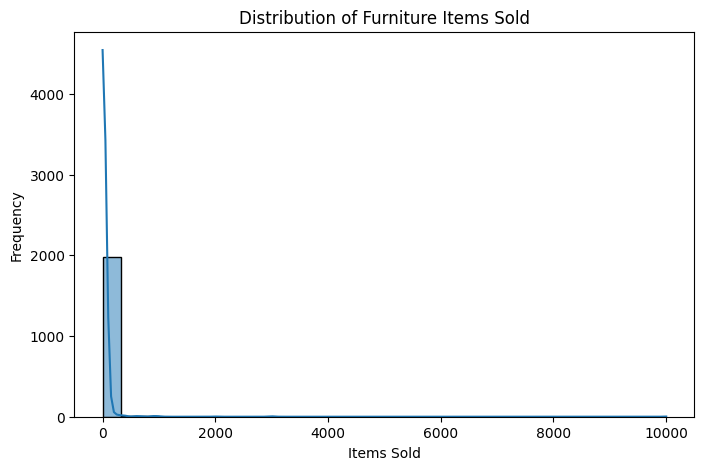

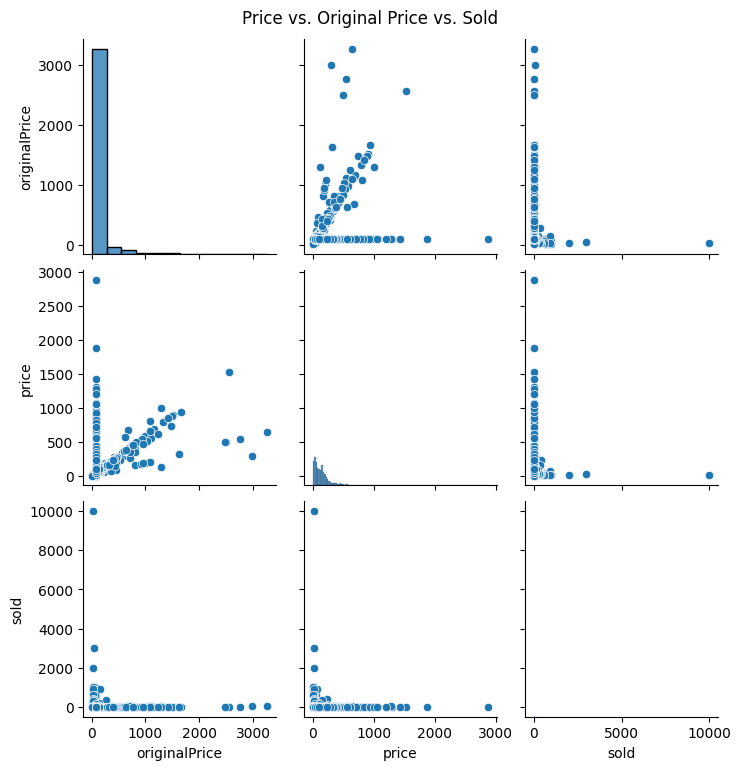

<ipython-input-27-463522c28a24>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Shipping Type', x='Count', data=shipping_counts, palette="Blues_r")


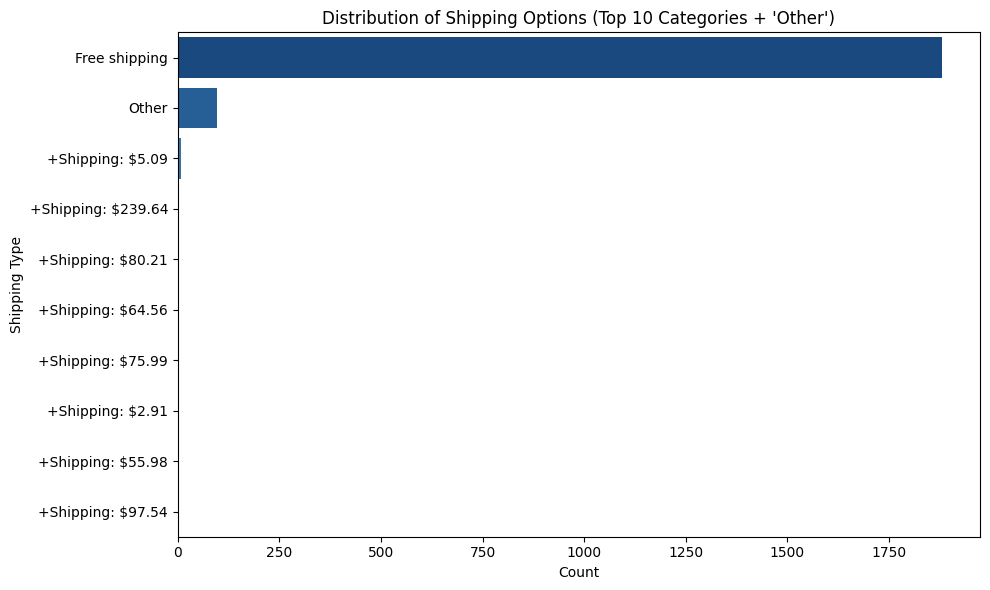

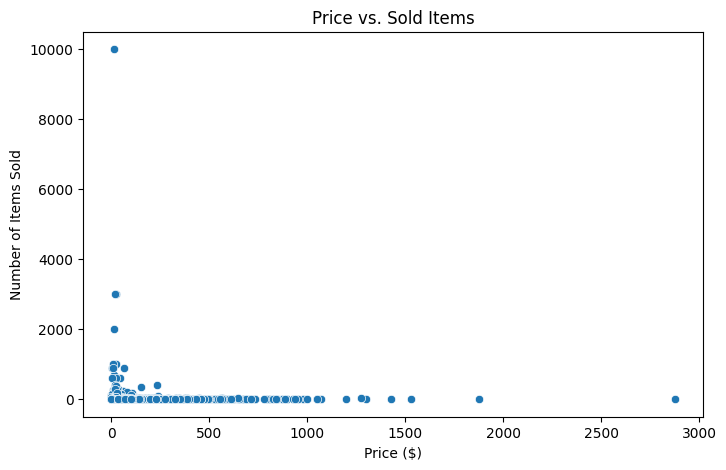

In [27]:

# 3 EDA

plt.figure(figsize=(8,5))
sns.histplot(df['sold'], bins=30, kde=True)
plt.title('Distribution of Furniture Items Sold')
plt.xlabel('Items Sold')
plt.ylabel('Frequency')
plt.show()

print("\n" * 3)

# Relationship between price, originalPrice, and sold
if all(col in df.columns for col in ['originalPrice', 'price', 'sold']):
    sns.pairplot(df[['originalPrice', 'price', 'sold']])
    plt.suptitle('Price vs. Original Price vs. Sold', y=1.02)
    plt.show()

    print("\n" * 3)

# Countplot (Shipping Options) - Grouped Rare Categories
    if 'tagText' in df.columns:
      top_shipping = df['tagText'].value_counts().nlargest(10).index

    df['tagText'] = df['tagText'].apply(lambda x: x if x in top_shipping else "Other")

    shipping_counts = df['tagText'].value_counts().reset_index()
    shipping_counts.columns = ['Shipping Type', 'Count']
    shipping_counts = shipping_counts.sort_values(by='Count', ascending=False)

    plt.figure(figsize=(10, 6))

    #horizontal bar chart
    sns.barplot(y='Shipping Type', x='Count', data=shipping_counts, palette="Blues_r")

    plt.title("Distribution of Shipping Options (Top 10 Categories + 'Other')")
    plt.xlabel("Count")
    plt.ylabel("Shipping Type")
    plt.tight_layout()
    plt.show()

    print("\n" * 3)

    #
# Scatterplot: Price vs Sold
if 'price' in df.columns and 'sold' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='price', y='sold', data=df)
    plt.title('Price vs. Sold Items')
    plt.xlabel("Price ($)")
    plt.ylabel("Number of Items Sold")
    plt.show()


In [30]:
# 4 Feature Engineering

# Convert productTitle to numerical features using TF-IDF
if 'productTitle' in df.columns:
    tfidf = TfidfVectorizer(max_features=100)
    productTitle_tfidf = tfidf.fit_transform(df['productTitle'])
    productTitle_tfidf_df = pd.DataFrame(productTitle_tfidf.toarray(), columns=tfidf.get_feature_names_out())
    df = pd.concat([df, productTitle_tfidf_df], axis=1)
    df.drop('productTitle', axis=1, inplace=True)

    if 'tagText' in df.columns:
      shipping_counts = df['tagText'].value_counts()
    rare_categories = shipping_counts[shipping_counts < 10].index
    df['tagText'] = df['tagText'].apply(lambda x: "Other" if x in rare_categories else x)

    le = LabelEncoder()
    df['tagText'] = le.fit_transform(df['tagText'])

# Handle missing values
df.dropna(inplace=True)  # Drop rows with missing values

In [33]:
# 5 Model Selection & Training
# Define Features (X) and Target (y)
X = df.drop('sold', axis=1)
y = df['sold']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [39]:
# 6 MODEL EVALUATION


categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Update features (X) and target variable (y)
X = df_encoded.drop(columns=['sold'])  # Adjust 'sold' if your target variable is different
y = df_encoded['sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


# Calculate MSE and R²
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)




In [40]:
# 7 CONCLUSION
print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


Linear Regression - MSE: 6913.30, R²: -0.26
Random Forest - MSE: 6016.58, R²: -0.10
